In [61]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import spacy
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize
from nltk.tokenize import ToktokTokenizer
from numpy import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn import metrics 
from sklearn.metrics import confusion_matrix,classification_report
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.model_selection import train_test_split

import multiprocessing

In [62]:
#Loading the Dataset using pandas
df = pd.read_pickle('warehouse.pickle')
#df = df[pd.notnull(df['aboutus_text'])]
df

,crunchbase_ID,home_text,aboutus_text,overview_text,whatwedo_text,company_text,whoweare_text,AI
0,1916,Skip to main content Products GPU accelerated ...,NaN,NaN,NaN,NaN,NaN,1
1,1917,Our AIs Research Company Careers Get in Touch ...,NaN,NaN,NaN,Our AIs Research Company Careers Get in Touch ...,NaN,1
2,1918,Toggle navigation Product Projects Company His...,NaN,NaN,NaN,NaN,NaN,1
3,1919,Brainpeek Solutions Create a seamless online u...,Brainpeek Solutions Create a seamless online u...,NaN,NaN,NaN,NaN,1
4,1920,The Tool Our Languages Services Extract Produc...,The Tool Our Languages Services Extract Produc...,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...
4889,2735,Username or Email L senord Remember me Norsk S...,Username or Email L senord Remember me Norsk S...,NaN,NaN,NaN,NaN,0
4890,5944,Solutions Solution for distributors Covered re...,NaN,NaN,NaN,NaN,NaN,0
4891,5251,BROWSE PRODUCTS Variety Cases Pasta Mac and Ch...,NaN,NaN,NaN,NaN,NaN,0
4892,4225,Pricing Documentation Community Changelog Logi...,NaN,NaN,NaN,NaN,NaN,0


In [63]:
#Analysing type of data of df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4894 entries, 0 to 4893
Data columns (total 8 columns):
crunchbase_ID    4894 non-null object
home_text        4894 non-null object
aboutus_text     2212 non-null object
overview_text    66 non-null object
whatwedo_text    50 non-null object
company_text     477 non-null object
whoweare_text    83 non-null object
AI               4894 non-null int64
dtypes: int64(1), object(7)
memory usage: 306.0+ KB


In [64]:
#Counting NaN per column
home_NaN = df['home_text'].isna().sum()
print('Number of Nan in home_text: ', home_NaN)
aboutus_NaN = df['aboutus_text'].isna().sum()
print('Number of Nan in aboutus_text: ', aboutus_NaN)
whatwedo_NaN = df['whatwedo_text'].isna().sum()
print('Number of Nan in whatwedo_text: ', whatwedo_NaN)
company_NaN = df['company_text'].isna().sum()
print('Number of Nan in company_text: ', company_NaN)
whoweare_NaN = df['whoweare_text'].isna().sum()
print('Number of Nan in whoweare_text: ', whoweare_NaN)


Number of Nan in home_text:  0
Number of Nan in aboutus_text:  2682
Number of Nan in whatwedo_text:  4844
Number of Nan in company_text:  4417
Number of Nan in whoweare_text:  4811


In [65]:
#Getting new dataframe only with relevant columns and saving csv file
df3 = df[['home_text', 'AI']]
df3.to_csv('Study.csv')
df3


,home_text,AI
0,Skip to main content Products GPU accelerated ...,1
1,Our AIs Research Company Careers Get in Touch ...,1
2,Toggle navigation Product Projects Company His...,1
3,Brainpeek Solutions Create a seamless online u...,1
4,The Tool Our Languages Services Extract Produc...,1
...,...,...
4889,Username or Email L senord Remember me Norsk S...,0
4890,Solutions Solution for distributors Covered re...,0
4891,BROWSE PRODUCTS Variety Cases Pasta Mac and Ch...,0
4892,Pricing Documentation Community Changelog Logi...,0


In [66]:
#Check random home text to see the text
df.home_text.iloc[1234]

"Toggle navigation How it Works (current) Pricing FAQ Contact REQUEST DEMO AI powered helicopter patrols for Vegetation Management and Pole Top inspections Get useful information for multiple departments with a single flight. Our customizable reports are\n tailored to your unique workflows. REQUEST\n DEMO How it Works Get straight to the answers you need. We build a database of answers to your most pressing questions, so you don't have to analyze thousands of\n raw images or point clouds. We collect aerial data from manned helicopters or UAVs. Our AI analyzes data in the cloud. Our AI generates a searchable database of the status of every component and and its condition. Then it exports customizable reports of what each end user needs to know. A human expert reviews the reports for accuracy before publishing. The final results are available online via web portal, and as PDFs. Have your own reporting tools? Seamlessly integrate the available data into your existing workflows\n with our 

1    2447
0    2447
Name: AI, dtype: int64

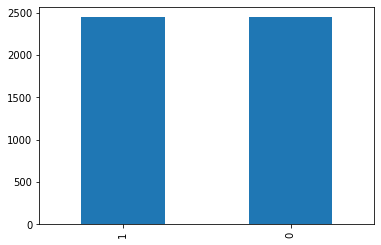

In [67]:
#Counting number of websites with AI to check distribution
df.AI.value_counts().sort_values().plot(kind = 'bar')
WithAI = df.AI.value_counts()
WithAI

In [68]:
#Splitting companies with/without AI and saving them in a CSV
WithAI = df[df.AI == 1]
NoAI = df[df.AI == 0]
WithAI.to_csv('WithAI.csv')
NoAI.to_csv('NoAI.csv')

In [69]:
#Pre-processing functions
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"'s", "", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r" m ", " am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"http", "", text)
    text = re.sub(r"[^A-Za-z]", " ", text)
    return text

tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    t = [token for token in tokens if token.lower() not in stopword_list]
    text = ' '.join(t)    
    return text

def stemmer(text):
    stemmer = SnowballStemmer('english')
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

def lemmatize(text):
    lem = WordNetLemmatizer()
    
    return  [lem.lemmatize(word) for word in text]

nlp = spacy.load('en_core_web_sm',parse=True,tag=True, entity=True)
def get_lem(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text


In [70]:
# cleaning dataframe
df = df3[['home_text', 'AI']]
df['home_text'] = df['home_text'].apply(lambda x:clean_text(x))
df['home_text'] = df['home_text'].apply(lambda x:stemmer(x))


In [71]:
#Spliting data
X_train,X_test,y_train,y_test=train_test_split(df['home_text'],df['AI'],test_size=0.15,random_state=37)

In [72]:
#Vectorizing and getting TF - IDF for the dataset
vectorizer=TfidfVectorizer()
tfidf_vect = vectorizer.fit(df['home_text'])
X_train_tfidf = tfidf_vect.transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

In [73]:
#Fitting model
clf=LinearSVC()
clf.fit(X_train_tfidf,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [74]:
#Prediction
pred = clf.predict(X_test_tfidf)

In [75]:
#Confusion matrix
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[322  45]
 [ 49 319]]
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       367
           1       0.88      0.87      0.87       368

    accuracy                           0.87       735
   macro avg       0.87      0.87      0.87       735
weighted avg       0.87      0.87      0.87       735



In [76]:
#Accuracy
metrics.accuracy_score(y_test,pred)

0.8721088435374149

In [17]:
#Word2vec&keras model to compare with LinearSVC

In [82]:
import gensim
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import keras

In [96]:
y = df["AI"].values
#Converting X to format acceptable by gensim
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in df["home_text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)


In [84]:
np.array(X)

array([list(['skip', 'main', 'content', 'product', 'gpu', 'acceler', 'databas', 'spotlyt', 'visualis', 'solut', 'retail', 'telecom', 'financ', 'logist', 'dna', 'oil', 'gas', 'resourc', 'blog', 'document', 'technic', 'support', 'video', 'white', 'paper', 'us', 'team', 'partner', 'custom', 'contact', 'world', 'fastest', 'advanc', 'gpu', 'databas', 'brytlyt', 'combin', 'power', 'gpus', 'patent', 'pend', 'ip', 'built', 'postgresql', 'gain', 'within', 'hour', 'deploy', 'time', 'faster', 'tradit', 'system', 'seamless', 'integr', 'exist', 'infrastructur', 'use', 'data', 'connector', 'featur', 'rich', 'easi', 'use', 'tool', 'base', 'postgresql', 'add', 'gpu', 'cloud', 'resourc', 'fli', 'system', 'scale', 'need', 'let', 'visualis', 'tool', 'slow', 'spotlyt', 'brytlyt', 'super', 'fast', 'analyt', 'workbench', 'complet', 'tool', 'analyst', 'data', 'scientist', 'busi', 'intellig', 'brytlyt', 'gpu', 'databas', 'smash', 'benchmark', 'record', 'independ', 'benchmark', 'brytlyt', 'gpu', 'databas', 'ou

In [97]:
#Dimension of vectors
EMBEDDING_DIM = 128

#Word2Vec model
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [98]:
#size
len(w2v_model.wv.vocab)

64608

In [99]:
w2v_model.wv.most_similar("sustain")

[('circular', 0.7809706926345825),
 ('ambit', 0.737944483757019),
 ('farmer', 0.734214186668396),
 ('economi', 0.7232407331466675),
 ('ecolog', 0.7229398488998413),
 ('environment', 0.720428466796875),
 ('green', 0.7161364555358887),
 ('aim', 0.7111292481422424),
 ('planet', 0.6923732757568359),
 ('climat', 0.6853830814361572)]

In [100]:
#Tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [101]:
#ectors
X[0][:10]

[744, 589, 105, 6, 2989, 517, 994, 30629, 4334, 15]

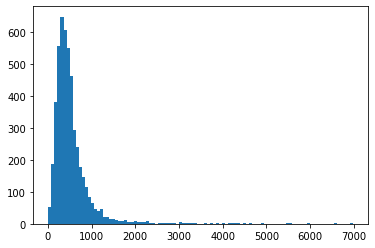

In [102]:
plt.hist([len(x) for x in X], bins=100)
plt.show()

In [103]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 500])

2987

In [104]:
#keep all the text that has 500 words or less
maxlen = 500 

#Making all the text with a max lenght of 500
X = pad_sequences(X, maxlen=maxlen)

In [105]:

len(X[1578])

500

In [106]:
#unknown added to the dictionary
vocab_size = len(tokenizer.word_index) + 1

In [107]:
#Weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix


In [108]:
#Getting embedding vectors
embedding_vectors = get_weight_matrix(w2v_model, word_index)

/Users/maxrojas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [109]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


In [110]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          8269952   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 8,401,665
Trainable params: 131,713
Non-trainable params: 8,269,952
_________________________________________________________________


In [111]:
#Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.15,random_state=1)
X_train

array([[    2,  1410,   160, ...,    12,   128,    32],
       [    0,     0,     0, ...,    99,    21,    40],
       [    0,     0,     0, ...,  1339,    21,    40],
       ...,
       [    0,     0,     0, ...,     5,   482,     5],
       [    0,     0,     0, ...,    95,    63, 11654],
       [    0,     0,     0, ..., 11468,  1324,  3056]], dtype=int32)

In [112]:
model.fit(X_train, y_train, validation_split=0.15, epochs=10, batch_size = 100)

Train on 3535 samples, validate on 624 samples
Epoch 1/10
3535/3535 [==============================] - 107s 30ms/sample - loss: 0.6940 - acc: 0.5533 - val_loss: 0.6644 - val_acc: 0.5962
Epoch 2/10
3535/3535 [==============================] - 100s 28ms/sample - loss: 0.6269 - acc: 0.6421 - val_loss: 0.6257 - val_acc: 0.6715
Epoch 3/10
3535/3535 [==============================] - 101s 28ms/sample - loss: 0.6724 - acc: 0.6280 - val_loss: 0.7133 - val_acc: 0.4968
Epoch 4/10
3535/3535 [==============================] - 103s 29ms/sample - loss: 0.6861 - acc: 0.5465 - val_loss: 0.6844 - val_acc: 0.5192
Epoch 5/10
3535/3535 [==============================] - 111s 32ms/sample - loss: 0.6635 - acc: 0.6110 - val_loss: 0.6498 - val_acc: 0.5994
Epoch 6/10
3535/3535 [==============================] - 112s 32ms/sample - loss: 0.5768 - acc: 0.7431 - val_loss: 0.5049 - val_acc: 0.7853
Epoch 7/10
3535/3535 [==============================] - 108s 31ms/sample - loss: 0.4970 - acc: 0.7700 - val_loss: 0.475

In [48]:
#model.save('word2vec')

In [45]:
y_pred = (model.predict(X_test) > 0.5)

In [46]:
accuracy_score(y_test, y_pred)

0.854421768707483

In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86       365
           1       0.87      0.84      0.85       370

    accuracy                           0.85       735
   macro avg       0.85      0.85      0.85       735
weighted avg       0.85      0.85      0.85       735

